# Every project starts with imports...

In [1]:
## For the sake of debugging
import pdb

## Data structures
import numpy as np 
import pandas as pd 

## Visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

## Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

## Models
# Tuning parameters
from sklearn.model_selection import GridSearchCV, cross_val_score

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Neural Network
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

## Evaluation
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

# Magic method used for displaying images directly in Jupyter Notebook
%matplotlib inline

Using TensorFlow backend.


# Loading up the data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
datasets = [train_df, test_df]

# Data analysis

In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Check for missing data

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
def show_missing_values():
    nulls = train_df.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


### Missing Data - conclusions

There are missing values in three columns. 

First of them is 'Age' - there are 177 of 891 values are missing. Only two rows are missing in case of 'Embarked'. There are far less values of 'Cabin' column - only 204 of 891 are available.

Fonrtunately there are plenty of methods of dealing with such problems, but this problem will be solved later.

## Dependencies between data
A key to creating a good model is learning how does the data correlate - what are the dependencies between various attributes.

## Sex
There is a disparity between survivors depending on the sex - women were more likely to survive.

Text(0.5, 1.0, 'Survivors depending on the sex')

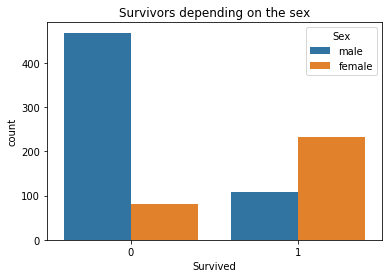

In [6]:
sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.title('Survivors depending on the sex')

## Embarked
Most of the casualties were embarked in 'S'.

Text(0.5, 1.0, 'Survivors depending on the emberkment place')

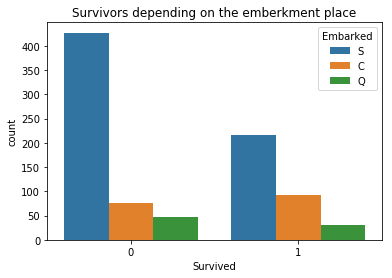

In [7]:
sns.countplot(x='Survived', hue='Embarked', data=train_df)
plt.title('Survivors depending on the emberkment place')

## Pclass
Passengers from the 3rd class were more likely to die during the cruise - they were the most of the casualties.
The number of people that survived, depending on the class, was rather even.

Text(0.5, 1.0, 'Survivors depending on the class')

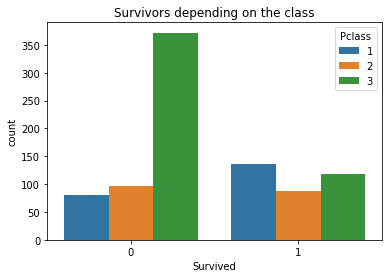

In [8]:
sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.title('Survivors depending on the class')

## Age
Male: 
* most of the survivors were between ages 20 to 40   

Female: 
* more survivors overall
* the difference between survival rate based on age is smaller than in case of men

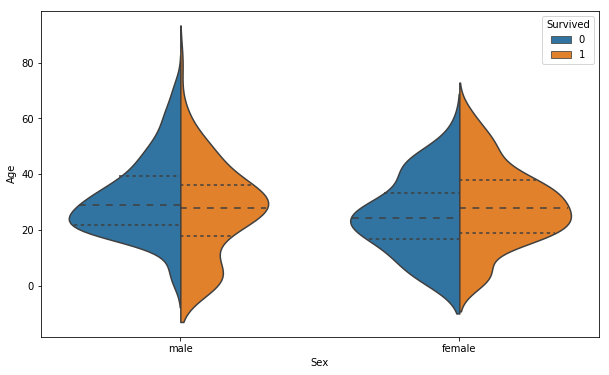

In [9]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_df, split=True, inner="quartile")

## Fare
It seems that passengers with cheaper tickets were more likely to die.

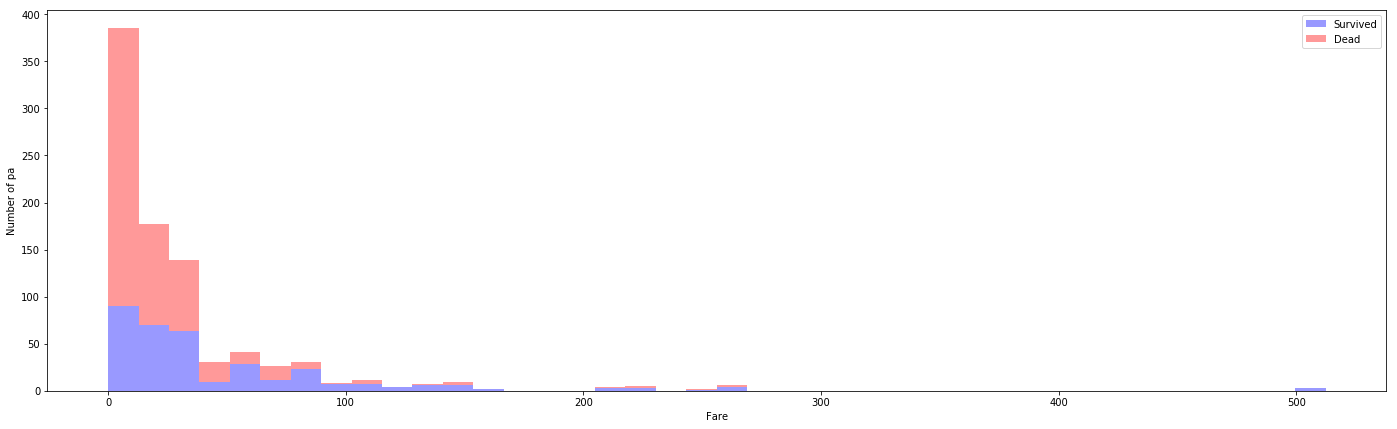

In [10]:
survived = train_df[train_df['Survived'] == 1]['Fare']
dead = train_df[train_df['Survived'] == 0]['Fare']

figure = plt.figure(figsize=(24,7))
plt.hist([survived, dead], stacked=True, color=['b','r'], alpha=0.4, bins=40, label=['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of pa')
plt.legend()

# Data Preprocessing

## Dropping unrelevant data
Some of the data does not have any impact on the survival rate of the passengers and only increases the complexity of the dataset - it has to be erased.

### PassengerId, Ticket, Name
* PassengerId - it is only ordinal number of the passenger, does not influence survival rate
* Ticket - too much variance between tickets
* Name - would not be so relevant to the surviving the accident. But we will use it to fill the blank 'Age' values

In [11]:
columns_to_drop = ['PassengerId', 'Ticket', 'Name']
for d in datasets:
    d.drop(columns_to_drop, axis=1, inplace=True)

## Dealing with missing data
### Age 

An example approach would have be using for instance a mean to fill the blank 'Age' values

In [12]:
def fill_empty_age(dataset): 
    mean = dataset['Age'].mean()
    std = dataset['Age'].std()
    
    dataset['Age'].fillna(np.random.randint(mean - std, mean + std))
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

for d in datasets:
    fill_empty_age(d)

### Embarked
A standard approach is to fill missing data with the one that is most frequent - in this case Embarkment 'S'.

In [13]:
most_frequent_embarked = train_df['Embarked'].value_counts().axes[0][0]
most_frequent_embarked

'S'

In [14]:
imputer = SimpleImputer(missing_values='NaN', strategy='most_frequent')
for dataset in datasets:
    imputer.fit_transform(d)

### Cabin
There is a lot of missing information in this column - about 80%. It can be erased from the datasets.

In [15]:
for d in datasets: 
    d.drop('Cabin', axis=1, inplace=True)

## Categorical Features

The function below adds dummy columns from the given column and drops the original one.

In [16]:
def create_categorical_feature(dataset, column_to_modify):
    categorical = pd.get_dummies(dataset[column_to_modify], prefix=column_to_modify)
    dataset.drop(column_to_modify, axis=1, inplace=True)
    dataset = pd.concat([dataset, categorical], axis=1)
    return dataset

### Pclass

In [17]:
column = 'Pclass'
train_df = create_categorical_feature(train_df, column)
test_df = create_categorical_feature(test_df, column)

### Embarked

In [18]:
column = 'Embarked'
train_df = create_categorical_feature(train_df, column)
test_df = create_categorical_feature(test_df, column)

### Sex
There is no need for having two columns denoting sex - it only increases the complexity of the data.   
A good solution would be to drop one of the columns and keep the one denoting for instance if the person is male (1) or not (0).

In [19]:
def create_categorical_sex(dataset):
    encoder = LabelBinarizer()
    sex_categories = dataset['Sex']
    sex_categories_encoded = encoder.fit_transform(sex_categories)
    dataset['isMale'] = sex_categories_encoded
    dataset.drop('Sex', axis=1, inplace=True)
    return dataset

train_df = create_categorical_sex(train_df)
test_df = create_categorical_sex(test_df)

### Age

First convert continuous values to caregorical ones, by definining bins in which adequate ages will end up.

In [20]:
def categorize_ages(df):
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Old Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

train_df = categorize_ages(train_df)
test_df = categorize_ages(test_df)

Create dummy variables from categorized ages.

In [21]:
column = 'Age'
train_df = create_categorical_feature(train_df, 'Age')
test_df = create_categorical_feature(test_df, 'Age')

### Fare

In [22]:
pd.qcut(train_df['Fare'], 5).value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: Fare, dtype: int64

In [23]:
def convert_fares(fare): 
    if fare <= 7.854: 
        return 0
    elif fare > 7.854 and fare <= 10.5: 
        return 1
    elif fare > 10.5 and fare <= 21.679:
        return 2
    elif fare > 21.679 and fare <= 39.688: 
        return 3
    else: 
        return 4

for dataset in datasets:
    dataset['Fare'] = dataset['Fare'].apply(lambda fare: convert_fares(fare))

## Feature Engineering
Columns 'SibSp' and 'Parch' denote very similar thing - number of relatives. This can be represented as one column 'Relatives'.

In [24]:
for d in datasets:
    relatives = d['SibSp'] + d['Parch']
    d['Relatives'] = relatives
    d.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [25]:
def split_datasets(dataset):    
    results_cols = ['Survived']
    prediction_cols = [col for col in dataset.columns if col not in results_cols]
    return dataset[prediction_cols], dataset[results_cols]

In [26]:
X_train, y_train = split_datasets(train_df)
y_train = y_train.values.ravel()
# X_test, y_test = split_datasets(test_df)

## Feature Scaling

In [27]:
scaler = StandardScaler()

def scale_features(dataset): 
    return scaler.fit_transform(dataset.astype(float))

In [28]:
X_train = scale_features(X_train)

# Create Models

Since the problem is a classification task, it will require classification models.   
Let's try SVM, RandomForest and a Simple Neural Network.

## GridSearch
In order to find best parameters of the classifiers GridSearch will be used.

In [29]:
def find_best_parameters(model, parameters, X, y, cv=10, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, scoring=make_scorer(accuracy_score), cv=cv, verbose=verbose, n_jobs=n_jobs, iid=True)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

## SVM

In [30]:
svm = SVC()

parameters = {'C': [1.0, 2.0, 4.0], 
              'gamma': [0.001, 0.1, 1., 10.]
             }

svm = find_best_parameters(svm, parameters, X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 113 out of 120 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.0s finished


## Random Forest

In [31]:
random_forest = RandomForestClassifier()

parameters = {'n_estimators': [20, 40, 80, 160], 
              'max_features': ['log2', 'sqrt','auto']
             }

random_forest = find_best_parameters(random_forest, parameters, X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.7s finished


## Simple Neural Network

A simple Artificial Neural Network with 15 input nodes (number of columns), 2 hidden layers and 1 output node.

In [32]:
def create_model(activation_func='relu'):
    
    model = Sequential()
    model.add(Dense(15, activation=activation_func))
    model.add(Dense(7, activation=activation_func))
    model.add(Dense(3, activation=activation_func))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [33]:
neural_net = KerasClassifier(build_fn=create_model, epochs=500, batch_size=32)
# history = neural_net.fit(X_train, y_train.as_matrix(), epochs=500, batch_size=32)

# Pick best model

In [34]:
def measure_classifier_accuracy(classifier, X, y):
    predictions = classifier.predict(X)
    return accuracy_score(y, predictions), confusion_matrix(y, predictions)

In [35]:
svm_scores = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=10)
random_forest_scores = cross_val_score(random_forest, X_train, y_train, scoring='accuracy', cv=10)
neural_net_scores = cross_val_score(neural_net, X_train, y_train, scoring='accuracy', cv=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
801/801 [==============================] - 0s 422us/step - loss: 0.6928 - acc: 0.6005
Epoch 2/500
801/801 [==============================] - 0s 76us/step - loss: 0.6901 - acc: 0.6217
Epoch 3/500
801/801 [==============================] - 0s 60us/step - loss: 0.6883 - acc: 0.6255
Epoch 4/500
801/801 [==============================] - 0s 56us/step - loss: 0.6860 - acc: 0.6305
Epoch 5/500
801/801 [==============================] - 0s 64us/step - loss: 0.6838 - acc: 0.6317
Epoch 6/500
801/801 [==============================] - 0s 76us/step - loss: 0.6802 - acc: 0.6404
Epoch 7/500
801/801 [==============================] - 0s 67us/step - loss: 0.6748 - acc: 0.6467
Epoch 8/500
801/801 [==============================] - 0s 55us/step - loss: 0.6652 - acc: 0.6567
Epoch 9/500
801/801 [==============================] - 0s 56us/step - loss: 0.6481 - acc: 0.6617
Epoch 

801/801 [==============================] - 0s 65us/step - loss: 0.3514 - acc: 0.8502
Epoch 79/500
801/801 [==============================] - 0s 56us/step - loss: 0.3502 - acc: 0.8527
Epoch 80/500
801/801 [==============================] - 0s 56us/step - loss: 0.3493 - acc: 0.8502
Epoch 81/500
801/801 [==============================] - 0s 46us/step - loss: 0.3473 - acc: 0.8527
Epoch 82/500
801/801 [==============================] - 0s 58us/step - loss: 0.3474 - acc: 0.8464
Epoch 83/500
801/801 [==============================] - 0s 54us/step - loss: 0.3477 - acc: 0.8464
Epoch 84/500
801/801 [==============================] - 0s 53us/step - loss: 0.3468 - acc: 0.8514
Epoch 85/500
801/801 [==============================] - 0s 56us/step - loss: 0.3459 - acc: 0.8464
Epoch 86/500
801/801 [==============================] - 0s 60us/step - loss: 0.3461 - acc: 0.8489
Epoch 87/500
801/801 [==============================] - 0s 57us/step - loss: 0.3441 - acc: 0.8477
Epoch 88/500
801/801 [===========

801/801 [==============================] - 0s 58us/step - loss: 0.3209 - acc: 0.8652
Epoch 162/500
801/801 [==============================] - 0s 51us/step - loss: 0.3212 - acc: 0.8677
Epoch 163/500
801/801 [==============================] - 0s 57us/step - loss: 0.3201 - acc: 0.8664
Epoch 164/500
801/801 [==============================] - 0s 60us/step - loss: 0.3192 - acc: 0.8639
Epoch 165/500
801/801 [==============================] - 0s 58us/step - loss: 0.3181 - acc: 0.8664
Epoch 166/500
801/801 [==============================] - 0s 43us/step - loss: 0.3183 - acc: 0.8677
Epoch 167/500
801/801 [==============================] - 0s 58us/step - loss: 0.3182 - acc: 0.8677
Epoch 168/500
801/801 [==============================] - 0s 54us/step - loss: 0.3196 - acc: 0.8677
Epoch 169/500
801/801 [==============================] - 0s 49us/step - loss: 0.3182 - acc: 0.8677
Epoch 170/500
801/801 [==============================] - 0s 58us/step - loss: 0.3176 - acc: 0.8677
Epoch 171/500
801/801 [=

801/801 [==============================] - 0s 53us/step - loss: 0.3020 - acc: 0.8764
Epoch 244/500
801/801 [==============================] - 0s 68us/step - loss: 0.3028 - acc: 0.8739
Epoch 245/500
801/801 [==============================] - 0s 59us/step - loss: 0.3037 - acc: 0.8727
Epoch 246/500
801/801 [==============================] - 0s 67us/step - loss: 0.3065 - acc: 0.8727
Epoch 247/500
801/801 [==============================] - 0s 52us/step - loss: 0.3041 - acc: 0.8789
Epoch 248/500
801/801 [==============================] - 0s 61us/step - loss: 0.3013 - acc: 0.8789
Epoch 249/500
801/801 [==============================] - 0s 41us/step - loss: 0.3000 - acc: 0.8764
Epoch 250/500
801/801 [==============================] - 0s 59us/step - loss: 0.2991 - acc: 0.8752
Epoch 251/500
801/801 [==============================] - 0s 60us/step - loss: 0.2990 - acc: 0.8752
Epoch 252/500
801/801 [==============================] - 0s 59us/step - loss: 0.2989 - acc: 0.8764
Epoch 253/500
801/801 [=

801/801 [==============================] - 0s 55us/step - loss: 0.3021 - acc: 0.8652
Epoch 326/500
801/801 [==============================] - 0s 55us/step - loss: 0.3028 - acc: 0.8577
Epoch 327/500
801/801 [==============================] - 0s 60us/step - loss: 0.2971 - acc: 0.8614
Epoch 328/500
801/801 [==============================] - 0s 57us/step - loss: 0.2943 - acc: 0.8639
Epoch 329/500
801/801 [==============================] - 0s 51us/step - loss: 0.2966 - acc: 0.8677
Epoch 330/500
801/801 [==============================] - 0s 54us/step - loss: 0.2960 - acc: 0.8652
Epoch 331/500
801/801 [==============================] - 0s 58us/step - loss: 0.2987 - acc: 0.8689
Epoch 332/500
801/801 [==============================] - 0s 59us/step - loss: 0.2983 - acc: 0.8639
Epoch 333/500
801/801 [==============================] - 0s 48us/step - loss: 0.2935 - acc: 0.8727
Epoch 334/500
801/801 [==============================] - 0s 59us/step - loss: 0.2902 - acc: 0.8752
Epoch 335/500
801/801 [=

801/801 [==============================] - 0s 47us/step - loss: 0.2815 - acc: 0.8801
Epoch 408/500
801/801 [==============================] - 0s 61us/step - loss: 0.2810 - acc: 0.8814
Epoch 409/500
801/801 [==============================] - 0s 59us/step - loss: 0.2806 - acc: 0.8814
Epoch 410/500
801/801 [==============================] - 0s 57us/step - loss: 0.2807 - acc: 0.8789
Epoch 411/500
801/801 [==============================] - 0s 57us/step - loss: 0.2810 - acc: 0.8801
Epoch 412/500
801/801 [==============================] - 0s 53us/step - loss: 0.2853 - acc: 0.8801
Epoch 413/500
801/801 [==============================] - 0s 44us/step - loss: 0.2842 - acc: 0.8814
Epoch 414/500
801/801 [==============================] - 0s 64us/step - loss: 0.2839 - acc: 0.8826
Epoch 415/500
801/801 [==============================] - 0s 42us/step - loss: 0.2833 - acc: 0.8752
Epoch 416/500
801/801 [==============================] - 0s 63us/step - loss: 0.2831 - acc: 0.8839
Epoch 417/500
801/801 [=

801/801 [==============================] - 0s 66us/step - loss: 0.2755 - acc: 0.8889
Epoch 490/500
801/801 [==============================] - 0s 55us/step - loss: 0.2759 - acc: 0.8864
Epoch 491/500
801/801 [==============================] - 0s 61us/step - loss: 0.2756 - acc: 0.8839
Epoch 492/500
801/801 [==============================] - 0s 53us/step - loss: 0.2809 - acc: 0.8876
Epoch 493/500
801/801 [==============================] - 0s 43us/step - loss: 0.2776 - acc: 0.8851
Epoch 494/500
801/801 [==============================] - 0s 65us/step - loss: 0.2754 - acc: 0.8864
Epoch 495/500
801/801 [==============================] - 0s 42us/step - loss: 0.2747 - acc: 0.8876
Epoch 496/500
801/801 [==============================] - 0s 59us/step - loss: 0.2740 - acc: 0.8851
Epoch 497/500
801/801 [==============================] - 0s 51us/step - loss: 0.2737 - acc: 0.8876
Epoch 498/500
801/801 [==============================] - 0s 61us/step - loss: 0.2736 - acc: 0.8851
Epoch 499/500
801/801 [=

802/802 [==============================] - 0s 52us/step - loss: 0.3770 - acc: 0.8591
Epoch 73/500
802/802 [==============================] - 0s 62us/step - loss: 0.3748 - acc: 0.8566
Epoch 74/500
802/802 [==============================] - 0s 60us/step - loss: 0.3744 - acc: 0.8591
Epoch 75/500
802/802 [==============================] - 0s 62us/step - loss: 0.3732 - acc: 0.8566
Epoch 76/500
802/802 [==============================] - 0s 55us/step - loss: 0.3712 - acc: 0.8541
Epoch 77/500
802/802 [==============================] - 0s 45us/step - loss: 0.3710 - acc: 0.8628
Epoch 78/500
802/802 [==============================] - 0s 61us/step - loss: 0.3698 - acc: 0.8591
Epoch 79/500
802/802 [==============================] - 0s 42us/step - loss: 0.3691 - acc: 0.8579
Epoch 80/500
802/802 [==============================] - 0s 60us/step - loss: 0.3683 - acc: 0.8554
Epoch 81/500
802/802 [==============================] - 0s 43us/step - loss: 0.3667 - acc: 0.8566
Epoch 82/500
802/802 [===========

802/802 [==============================] - 0s 64us/step - loss: 0.3256 - acc: 0.8728
Epoch 156/500
802/802 [==============================] - 0s 62us/step - loss: 0.3242 - acc: 0.8766
Epoch 157/500
802/802 [==============================] - 0s 53us/step - loss: 0.3222 - acc: 0.8803
Epoch 158/500
802/802 [==============================] - 0s 74us/step - loss: 0.3234 - acc: 0.8803
Epoch 159/500
802/802 [==============================] - 0s 57us/step - loss: 0.3227 - acc: 0.8803
Epoch 160/500
802/802 [==============================] - 0s 62us/step - loss: 0.3220 - acc: 0.8815
Epoch 161/500
802/802 [==============================] - 0s 63us/step - loss: 0.3230 - acc: 0.8791
Epoch 162/500
802/802 [==============================] - 0s 61us/step - loss: 0.3249 - acc: 0.8791
Epoch 163/500
802/802 [==============================] - 0s 50us/step - loss: 0.3288 - acc: 0.8703
Epoch 164/500
802/802 [==============================] - 0s 56us/step - loss: 0.3240 - acc: 0.8766
Epoch 165/500
802/802 [=

802/802 [==============================] - 0s 54us/step - loss: 0.3060 - acc: 0.8890
Epoch 238/500
802/802 [==============================] - 0s 53us/step - loss: 0.3073 - acc: 0.8878
Epoch 239/500
802/802 [==============================] - 0s 55us/step - loss: 0.3074 - acc: 0.8828
Epoch 240/500
802/802 [==============================] - 0s 60us/step - loss: 0.3076 - acc: 0.8815
Epoch 241/500
802/802 [==============================] - 0s 41us/step - loss: 0.3054 - acc: 0.8840
Epoch 242/500
802/802 [==============================] - 0s 66us/step - loss: 0.3080 - acc: 0.8815
Epoch 243/500
802/802 [==============================] - 0s 43us/step - loss: 0.3084 - acc: 0.8778
Epoch 244/500
802/802 [==============================] - 0s 56us/step - loss: 0.3085 - acc: 0.8791
Epoch 245/500
802/802 [==============================] - 0s 62us/step - loss: 0.3055 - acc: 0.8803
Epoch 246/500
802/802 [==============================] - 0s 59us/step - loss: 0.3059 - acc: 0.8791
Epoch 247/500
802/802 [=

802/802 [==============================] - 0s 61us/step - loss: 0.3006 - acc: 0.8815
Epoch 320/500
802/802 [==============================] - 0s 56us/step - loss: 0.2993 - acc: 0.8865
Epoch 321/500
802/802 [==============================] - 0s 76us/step - loss: 0.3010 - acc: 0.8853
Epoch 322/500
802/802 [==============================] - 0s 62us/step - loss: 0.2983 - acc: 0.8828
Epoch 323/500
802/802 [==============================] - 0s 61us/step - loss: 0.3053 - acc: 0.8803
Epoch 324/500
802/802 [==============================] - 0s 62us/step - loss: 0.3020 - acc: 0.8840
Epoch 325/500
802/802 [==============================] - 0s 62us/step - loss: 0.2993 - acc: 0.8840
Epoch 326/500
802/802 [==============================] - 0s 47us/step - loss: 0.2976 - acc: 0.8840
Epoch 327/500
802/802 [==============================] - 0s 67us/step - loss: 0.2966 - acc: 0.8853
Epoch 328/500
802/802 [==============================] - 0s 46us/step - loss: 0.2985 - acc: 0.8878
Epoch 329/500
802/802 [=

802/802 [==============================] - 0s 55us/step - loss: 0.2955 - acc: 0.8815
Epoch 402/500
802/802 [==============================] - 0s 55us/step - loss: 0.2949 - acc: 0.8828
Epoch 403/500
802/802 [==============================] - 0s 59us/step - loss: 0.2952 - acc: 0.8853
Epoch 404/500
802/802 [==============================] - 0s 59us/step - loss: 0.2967 - acc: 0.8840
Epoch 405/500
802/802 [==============================] - 0s 54us/step - loss: 0.2975 - acc: 0.8853
Epoch 406/500
802/802 [==============================] - 0s 64us/step - loss: 0.2998 - acc: 0.8878
Epoch 407/500
802/802 [==============================] - 0s 43us/step - loss: 0.2995 - acc: 0.8878
Epoch 408/500
802/802 [==============================] - 0s 57us/step - loss: 0.2972 - acc: 0.8853
Epoch 409/500
802/802 [==============================] - 0s 65us/step - loss: 0.2962 - acc: 0.8865
Epoch 410/500
802/802 [==============================] - 0s 42us/step - loss: 0.2959 - acc: 0.8828
Epoch 411/500
802/802 [=

802/802 [==============================] - 0s 66us/step - loss: 0.2951 - acc: 0.8828
Epoch 484/500
802/802 [==============================] - 0s 61us/step - loss: 0.2929 - acc: 0.8815
Epoch 485/500
802/802 [==============================] - 0s 62us/step - loss: 0.2973 - acc: 0.8803
Epoch 486/500
802/802 [==============================] - 0s 43us/step - loss: 0.2939 - acc: 0.8791
Epoch 487/500
802/802 [==============================] - 0s 62us/step - loss: 0.2922 - acc: 0.8865
Epoch 488/500
802/802 [==============================] - 0s 53us/step - loss: 0.2905 - acc: 0.8878
Epoch 489/500
802/802 [==============================] - 0s 54us/step - loss: 0.2904 - acc: 0.8878
Epoch 490/500
802/802 [==============================] - 0s 60us/step - loss: 0.2909 - acc: 0.8828
Epoch 491/500
802/802 [==============================] - 0s 54us/step - loss: 0.2901 - acc: 0.8853
Epoch 492/500
802/802 [==============================] - 0s 63us/step - loss: 0.2912 - acc: 0.8865
Epoch 493/500
802/802 [=

802/802 [==============================] - 0s 65us/step - loss: 0.3398 - acc: 0.8541
Epoch 67/500
802/802 [==============================] - 0s 87us/step - loss: 0.3397 - acc: 0.8541
Epoch 68/500
802/802 [==============================] - 0s 113us/step - loss: 0.3382 - acc: 0.8566
Epoch 69/500
802/802 [==============================] - 0s 124us/step - loss: 0.3374 - acc: 0.8491
Epoch 70/500
802/802 [==============================] - 0s 82us/step - loss: 0.3371 - acc: 0.8516
Epoch 71/500
802/802 [==============================] - 0s 78us/step - loss: 0.3367 - acc: 0.8541
Epoch 72/500
802/802 [==============================] - 0s 83us/step - loss: 0.3365 - acc: 0.8516
Epoch 73/500
802/802 [==============================] - 0s 63us/step - loss: 0.3347 - acc: 0.8566
Epoch 74/500
802/802 [==============================] - 0s 66us/step - loss: 0.3351 - acc: 0.8541
Epoch 75/500
802/802 [==============================] - 0s 57us/step - loss: 0.3348 - acc: 0.8491
Epoch 76/500
802/802 [=========

802/802 [==============================] - 0s 60us/step - loss: 0.3035 - acc: 0.8803
Epoch 150/500
802/802 [==============================] - 0s 63us/step - loss: 0.3044 - acc: 0.8691
Epoch 151/500
802/802 [==============================] - 0s 64us/step - loss: 0.3072 - acc: 0.8778
Epoch 152/500
802/802 [==============================] - 0s 61us/step - loss: 0.3043 - acc: 0.8753
Epoch 153/500
802/802 [==============================] - 0s 72us/step - loss: 0.3023 - acc: 0.8766
Epoch 154/500
802/802 [==============================] - 0s 52us/step - loss: 0.3011 - acc: 0.8766
Epoch 155/500
802/802 [==============================] - 0s 63us/step - loss: 0.3024 - acc: 0.8791
Epoch 156/500
802/802 [==============================] - 0s 60us/step - loss: 0.3016 - acc: 0.8791
Epoch 157/500
802/802 [==============================] - 0s 60us/step - loss: 0.3020 - acc: 0.8753
Epoch 158/500
802/802 [==============================] - 0s 75us/step - loss: 0.3069 - acc: 0.8791
Epoch 159/500
802/802 [=

802/802 [==============================] - 0s 67us/step - loss: 0.2863 - acc: 0.8865
Epoch 232/500
802/802 [==============================] - 0s 74us/step - loss: 0.2861 - acc: 0.8840
Epoch 233/500
802/802 [==============================] - 0s 50us/step - loss: 0.2898 - acc: 0.8840
Epoch 234/500
802/802 [==============================] - 0s 68us/step - loss: 0.2886 - acc: 0.8803
Epoch 235/500
802/802 [==============================] - 0s 47us/step - loss: 0.2899 - acc: 0.8791
Epoch 236/500
802/802 [==============================] - 0s 64us/step - loss: 0.2997 - acc: 0.8753
Epoch 237/500
802/802 [==============================] - 0s 58us/step - loss: 0.2868 - acc: 0.8865
Epoch 238/500
802/802 [==============================] - 0s 58us/step - loss: 0.2857 - acc: 0.8865
Epoch 239/500
802/802 [==============================] - 0s 44us/step - loss: 0.2857 - acc: 0.8853
Epoch 240/500
802/802 [==============================] - 0s 61us/step - loss: 0.2854 - acc: 0.8815
Epoch 241/500
802/802 [=

802/802 [==============================] - 0s 74us/step - loss: 0.2788 - acc: 0.8903
Epoch 314/500
802/802 [==============================] - 0s 79us/step - loss: 0.2768 - acc: 0.8865
Epoch 315/500
802/802 [==============================] - 0s 63us/step - loss: 0.2850 - acc: 0.8691
Epoch 316/500
802/802 [==============================] - 0s 53us/step - loss: 0.2778 - acc: 0.8803
Epoch 317/500
802/802 [==============================] - 0s 64us/step - loss: 0.2798 - acc: 0.8815
Epoch 318/500
802/802 [==============================] - 0s 52us/step - loss: 0.2801 - acc: 0.8840
Epoch 319/500
802/802 [==============================] - 0s 51us/step - loss: 0.2786 - acc: 0.8766
Epoch 320/500
802/802 [==============================] - 0s 61us/step - loss: 0.2769 - acc: 0.8865
Epoch 321/500
802/802 [==============================] - 0s 62us/step - loss: 0.2758 - acc: 0.8840
Epoch 322/500
802/802 [==============================] - 0s 53us/step - loss: 0.2805 - acc: 0.8815
Epoch 323/500
802/802 [=

802/802 [==============================] - 0s 66us/step - loss: 0.2718 - acc: 0.8915
Epoch 396/500
802/802 [==============================] - 0s 66us/step - loss: 0.2697 - acc: 0.8928
Epoch 397/500
802/802 [==============================] - 0s 60us/step - loss: 0.2689 - acc: 0.8940
Epoch 398/500
802/802 [==============================] - 0s 59us/step - loss: 0.2685 - acc: 0.8928
Epoch 399/500
802/802 [==============================] - 0s 62us/step - loss: 0.2739 - acc: 0.8865
Epoch 400/500
802/802 [==============================] - 0s 54us/step - loss: 0.2749 - acc: 0.8815
Epoch 401/500
802/802 [==============================] - 0s 59us/step - loss: 0.2705 - acc: 0.8903
Epoch 402/500
802/802 [==============================] - 0s 44us/step - loss: 0.2683 - acc: 0.8890
Epoch 403/500
802/802 [==============================] - 0s 63us/step - loss: 0.2684 - acc: 0.8865
Epoch 404/500
802/802 [==============================] - 0s 62us/step - loss: 0.2673 - acc: 0.8940
Epoch 405/500
802/802 [=

802/802 [==============================] - 0s 70us/step - loss: 0.2608 - acc: 0.8940
Epoch 478/500
802/802 [==============================] - 0s 74us/step - loss: 0.2625 - acc: 0.8903
Epoch 479/500
802/802 [==============================] - 0s 75us/step - loss: 0.2667 - acc: 0.8940
Epoch 480/500
802/802 [==============================] - 0s 54us/step - loss: 0.2644 - acc: 0.8940
Epoch 481/500
802/802 [==============================] - 0s 46us/step - loss: 0.2634 - acc: 0.8940
Epoch 482/500
802/802 [==============================] - 0s 63us/step - loss: 0.2628 - acc: 0.8953
Epoch 483/500
802/802 [==============================] - 0s 71us/step - loss: 0.2629 - acc: 0.8878
Epoch 484/500
802/802 [==============================] - 0s 62us/step - loss: 0.2591 - acc: 0.8953
Epoch 485/500
802/802 [==============================] - 0s 66us/step - loss: 0.2603 - acc: 0.8953
Epoch 486/500
802/802 [==============================] - 0s 64us/step - loss: 0.2651 - acc: 0.8978
Epoch 487/500
802/802 [=

802/802 [==============================] - 0s 82us/step - loss: 0.3510 - acc: 0.8441
Epoch 61/500
802/802 [==============================] - 0s 78us/step - loss: 0.3447 - acc: 0.8579
Epoch 62/500
802/802 [==============================] - 0s 78us/step - loss: 0.3439 - acc: 0.8653
Epoch 63/500
802/802 [==============================] - 0s 47us/step - loss: 0.3438 - acc: 0.8628
Epoch 64/500
802/802 [==============================] - 0s 59us/step - loss: 0.3432 - acc: 0.8603
Epoch 65/500
802/802 [==============================] - 0s 47us/step - loss: 0.3444 - acc: 0.8516
Epoch 66/500
802/802 [==============================] - 0s 55us/step - loss: 0.3463 - acc: 0.8554
Epoch 67/500
802/802 [==============================] - 0s 78us/step - loss: 0.3451 - acc: 0.8566
Epoch 68/500
802/802 [==============================] - 0s 47us/step - loss: 0.3419 - acc: 0.8641
Epoch 69/500
802/802 [==============================] - 0s 61us/step - loss: 0.3409 - acc: 0.8628
Epoch 70/500
802/802 [===========

802/802 [==============================] - 0s 66us/step - loss: 0.3235 - acc: 0.8641
Epoch 144/500
802/802 [==============================] - 0s 57us/step - loss: 0.3222 - acc: 0.8691
Epoch 145/500
802/802 [==============================] - 0s 51us/step - loss: 0.3213 - acc: 0.8678
Epoch 146/500
802/802 [==============================] - 0s 66us/step - loss: 0.3211 - acc: 0.8691
Epoch 147/500
802/802 [==============================] - 0s 55us/step - loss: 0.3214 - acc: 0.8653
Epoch 148/500
802/802 [==============================] - 0s 59us/step - loss: 0.3216 - acc: 0.8703
Epoch 149/500
802/802 [==============================] - 0s 44us/step - loss: 0.3201 - acc: 0.8666
Epoch 150/500
802/802 [==============================] - 0s 68us/step - loss: 0.3214 - acc: 0.8703
Epoch 151/500
802/802 [==============================] - 0s 51us/step - loss: 0.3206 - acc: 0.8666
Epoch 152/500
802/802 [==============================] - 0s 68us/step - loss: 0.3202 - acc: 0.8678
Epoch 153/500
802/802 [=

802/802 [==============================] - 0s 68us/step - loss: 0.3081 - acc: 0.8728
Epoch 226/500
802/802 [==============================] - 0s 57us/step - loss: 0.3076 - acc: 0.8766
Epoch 227/500
802/802 [==============================] - 0s 56us/step - loss: 0.3100 - acc: 0.8703
Epoch 228/500
802/802 [==============================] - 0s 49us/step - loss: 0.3208 - acc: 0.8591
Epoch 229/500
802/802 [==============================] - 0s 55us/step - loss: 0.3172 - acc: 0.8653
Epoch 230/500
802/802 [==============================] - 0s 63us/step - loss: 0.3101 - acc: 0.8703
Epoch 231/500
802/802 [==============================] - 0s 47us/step - loss: 0.3073 - acc: 0.8703
Epoch 232/500
802/802 [==============================] - 0s 81us/step - loss: 0.3063 - acc: 0.8753
Epoch 233/500
802/802 [==============================] - 0s 63us/step - loss: 0.3078 - acc: 0.8741
Epoch 234/500
802/802 [==============================] - 0s 64us/step - loss: 0.3065 - acc: 0.8741
Epoch 235/500
802/802 [=

802/802 [==============================] - 0s 66us/step - loss: 0.2930 - acc: 0.8791
Epoch 308/500
802/802 [==============================] - 0s 73us/step - loss: 0.2919 - acc: 0.8803
Epoch 309/500
802/802 [==============================] - 0s 57us/step - loss: 0.2949 - acc: 0.8803
Epoch 310/500
802/802 [==============================] - 0s 46us/step - loss: 0.2934 - acc: 0.8828
Epoch 311/500
802/802 [==============================] - 0s 74us/step - loss: 0.2934 - acc: 0.8803
Epoch 312/500
802/802 [==============================] - 0s 51us/step - loss: 0.2928 - acc: 0.8778
Epoch 313/500
802/802 [==============================] - 0s 57us/step - loss: 0.2922 - acc: 0.8803
Epoch 314/500
802/802 [==============================] - 0s 61us/step - loss: 0.2919 - acc: 0.8753
Epoch 315/500
802/802 [==============================] - 0s 59us/step - loss: 0.2913 - acc: 0.8815
Epoch 316/500
802/802 [==============================] - 0s 65us/step - loss: 0.2925 - acc: 0.8791
Epoch 317/500
802/802 [=

802/802 [==============================] - 0s 68us/step - loss: 0.2812 - acc: 0.8828
Epoch 390/500
802/802 [==============================] - 0s 65us/step - loss: 0.2823 - acc: 0.8840
Epoch 391/500
802/802 [==============================] - 0s 73us/step - loss: 0.2811 - acc: 0.8853
Epoch 392/500
802/802 [==============================] - 0s 61us/step - loss: 0.2809 - acc: 0.8803
Epoch 393/500
802/802 [==============================] - 0s 59us/step - loss: 0.2803 - acc: 0.8865
Epoch 394/500
802/802 [==============================] - 0s 64us/step - loss: 0.2807 - acc: 0.8840
Epoch 395/500
802/802 [==============================] - 0s 67us/step - loss: 0.2803 - acc: 0.8840
Epoch 396/500
802/802 [==============================] - 0s 63us/step - loss: 0.2796 - acc: 0.8815
Epoch 397/500
802/802 [==============================] - 0s 59us/step - loss: 0.2806 - acc: 0.8828
Epoch 398/500
802/802 [==============================] - 0s 48us/step - loss: 0.2796 - acc: 0.8878
Epoch 399/500
802/802 [=

802/802 [==============================] - 0s 59us/step - loss: 0.3014 - acc: 0.8691
Epoch 472/500
802/802 [==============================] - 0s 58us/step - loss: 0.2822 - acc: 0.8840
Epoch 473/500
802/802 [==============================] - 0s 61us/step - loss: 0.3031 - acc: 0.8666
Epoch 474/500
802/802 [==============================] - 0s 76us/step - loss: 0.2777 - acc: 0.8803
Epoch 475/500
802/802 [==============================] - 0s 47us/step - loss: 0.2733 - acc: 0.8803
Epoch 476/500
802/802 [==============================] - 0s 68us/step - loss: 0.2740 - acc: 0.8865
Epoch 477/500
802/802 [==============================] - 0s 47us/step - loss: 0.2709 - acc: 0.8878
Epoch 478/500
802/802 [==============================] - 0s 62us/step - loss: 0.2717 - acc: 0.8865
Epoch 479/500
802/802 [==============================] - 0s 62us/step - loss: 0.2743 - acc: 0.8778
Epoch 480/500
802/802 [==============================] - 0s 59us/step - loss: 0.2745 - acc: 0.8803
Epoch 481/500
802/802 [=

802/802 [==============================] - 0s 75us/step - loss: 0.3775 - acc: 0.8404
Epoch 55/500
802/802 [==============================] - 0s 78us/step - loss: 0.3737 - acc: 0.8441
Epoch 56/500
802/802 [==============================] - 0s 70us/step - loss: 0.3738 - acc: 0.8441
Epoch 57/500
802/802 [==============================] - 0s 46us/step - loss: 0.3743 - acc: 0.8429
Epoch 58/500
802/802 [==============================] - 0s 63us/step - loss: 0.3728 - acc: 0.8479
Epoch 59/500
802/802 [==============================] - 0s 48us/step - loss: 0.3721 - acc: 0.8454
Epoch 60/500
802/802 [==============================] - 0s 62us/step - loss: 0.3709 - acc: 0.8479
Epoch 61/500
802/802 [==============================] - 0s 70us/step - loss: 0.3706 - acc: 0.8466
Epoch 62/500
802/802 [==============================] - 0s 63us/step - loss: 0.3698 - acc: 0.8479
Epoch 63/500
802/802 [==============================] - 0s 52us/step - loss: 0.3702 - acc: 0.8466
Epoch 64/500
802/802 [===========

802/802 [==============================] - 0s 49us/step - loss: 0.3362 - acc: 0.8603
Epoch 138/500
802/802 [==============================] - 0s 65us/step - loss: 0.3369 - acc: 0.8591
Epoch 139/500
802/802 [==============================] - 0s 71us/step - loss: 0.3358 - acc: 0.8579
Epoch 140/500
802/802 [==============================] - 0s 78us/step - loss: 0.3376 - acc: 0.8554
Epoch 141/500
802/802 [==============================] - 0s 58us/step - loss: 0.3365 - acc: 0.8529
Epoch 142/500
802/802 [==============================] - 0s 69us/step - loss: 0.3359 - acc: 0.8554
Epoch 143/500
802/802 [==============================] - 0s 48us/step - loss: 0.3346 - acc: 0.8566
Epoch 144/500
802/802 [==============================] - 0s 53us/step - loss: 0.3359 - acc: 0.8566
Epoch 145/500
802/802 [==============================] - 0s 66us/step - loss: 0.3342 - acc: 0.8541
Epoch 146/500
802/802 [==============================] - 0s 51us/step - loss: 0.3355 - acc: 0.8541
Epoch 147/500
802/802 [=

802/802 [==============================] - 0s 74us/step - loss: 0.3134 - acc: 0.8641
Epoch 220/500
802/802 [==============================] - 0s 95us/step - loss: 0.3190 - acc: 0.8566
Epoch 221/500
802/802 [==============================] - 0s 61us/step - loss: 0.3171 - acc: 0.8628
Epoch 222/500
802/802 [==============================] - 0s 49us/step - loss: 0.3155 - acc: 0.8653
Epoch 223/500
802/802 [==============================] - 0s 60us/step - loss: 0.3151 - acc: 0.8591
Epoch 224/500
802/802 [==============================] - 0s 49us/step - loss: 0.3124 - acc: 0.8653
Epoch 225/500
802/802 [==============================] - 0s 75us/step - loss: 0.3126 - acc: 0.8641
Epoch 226/500
802/802 [==============================] - 0s 62us/step - loss: 0.3148 - acc: 0.8666
Epoch 227/500
802/802 [==============================] - 0s 75us/step - loss: 0.3123 - acc: 0.8628
Epoch 228/500
802/802 [==============================] - 0s 68us/step - loss: 0.3135 - acc: 0.8603
Epoch 229/500
802/802 [=

802/802 [==============================] - 0s 76us/step - loss: 0.2964 - acc: 0.8728
Epoch 302/500
802/802 [==============================] - 0s 83us/step - loss: 0.2949 - acc: 0.8716
Epoch 303/500
802/802 [==============================] - 0s 76us/step - loss: 0.2961 - acc: 0.8753
Epoch 304/500
802/802 [==============================] - 0s 62us/step - loss: 0.2948 - acc: 0.8716
Epoch 305/500
802/802 [==============================] - 0s 73us/step - loss: 0.2963 - acc: 0.8728
Epoch 306/500
802/802 [==============================] - 0s 60us/step - loss: 0.2958 - acc: 0.8716
Epoch 307/500
802/802 [==============================] - 0s 65us/step - loss: 0.2976 - acc: 0.8678
Epoch 308/500
802/802 [==============================] - 0s 54us/step - loss: 0.2970 - acc: 0.8766
Epoch 309/500
802/802 [==============================] - 0s 66us/step - loss: 0.2984 - acc: 0.8703
Epoch 310/500
802/802 [==============================] - 0s 56us/step - loss: 0.3013 - acc: 0.8703
Epoch 311/500
802/802 [=

802/802 [==============================] - 0s 71us/step - loss: 0.2899 - acc: 0.8803
Epoch 384/500
802/802 [==============================] - 0s 79us/step - loss: 0.2893 - acc: 0.8728
Epoch 385/500
802/802 [==============================] - 0s 63us/step - loss: 0.2911 - acc: 0.8766
Epoch 386/500
802/802 [==============================] - 0s 54us/step - loss: 0.2896 - acc: 0.8803
Epoch 387/500
802/802 [==============================] - 0s 57us/step - loss: 0.2881 - acc: 0.8778
Epoch 388/500
802/802 [==============================] - 0s 49us/step - loss: 0.2892 - acc: 0.8753
Epoch 389/500
802/802 [==============================] - 0s 56us/step - loss: 0.2900 - acc: 0.8766
Epoch 390/500
802/802 [==============================] - 0s 66us/step - loss: 0.2881 - acc: 0.8791
Epoch 391/500
802/802 [==============================] - 0s 51us/step - loss: 0.2875 - acc: 0.8803
Epoch 392/500
802/802 [==============================] - 0s 70us/step - loss: 0.2869 - acc: 0.8791
Epoch 393/500
802/802 [=

802/802 [==============================] - 0s 56us/step - loss: 0.2848 - acc: 0.8778
Epoch 466/500
802/802 [==============================] - 0s 55us/step - loss: 0.2824 - acc: 0.8753
Epoch 467/500
802/802 [==============================] - 0s 65us/step - loss: 0.2856 - acc: 0.8778
Epoch 468/500
802/802 [==============================] - 0s 60us/step - loss: 0.2811 - acc: 0.8753
Epoch 469/500
802/802 [==============================] - 0s 49us/step - loss: 0.2823 - acc: 0.8741
Epoch 470/500
802/802 [==============================] - 0s 53us/step - loss: 0.2838 - acc: 0.8741
Epoch 471/500
802/802 [==============================] - 0s 65us/step - loss: 0.2807 - acc: 0.8840
Epoch 472/500
802/802 [==============================] - 0s 49us/step - loss: 0.2825 - acc: 0.8778
Epoch 473/500
802/802 [==============================] - 0s 63us/step - loss: 0.2810 - acc: 0.8778
Epoch 474/500
802/802 [==============================] - 0s 45us/step - loss: 0.2835 - acc: 0.8766
Epoch 475/500
802/802 [=

802/802 [==============================] - 0s 72us/step - loss: 0.3751 - acc: 0.8367
Epoch 49/500
802/802 [==============================] - 0s 86us/step - loss: 0.3739 - acc: 0.8416
Epoch 50/500
802/802 [==============================] - 0s 82us/step - loss: 0.3744 - acc: 0.8429
Epoch 51/500
802/802 [==============================] - 0s 70us/step - loss: 0.3725 - acc: 0.8429
Epoch 52/500
802/802 [==============================] - 0s 49us/step - loss: 0.3716 - acc: 0.8441
Epoch 53/500
802/802 [==============================] - 0s 63us/step - loss: 0.3710 - acc: 0.8429
Epoch 54/500
802/802 [==============================] - 0s 58us/step - loss: 0.3695 - acc: 0.8416
Epoch 55/500
802/802 [==============================] - 0s 83us/step - loss: 0.3684 - acc: 0.8454
Epoch 56/500
802/802 [==============================] - 0s 58us/step - loss: 0.3692 - acc: 0.8491
Epoch 57/500
802/802 [==============================] - 0s 58us/step - loss: 0.3680 - acc: 0.8479
Epoch 58/500
802/802 [===========

802/802 [==============================] - 0s 66us/step - loss: 0.3333 - acc: 0.8641
Epoch 132/500
802/802 [==============================] - 0s 68us/step - loss: 0.3331 - acc: 0.8641
Epoch 133/500
802/802 [==============================] - 0s 63us/step - loss: 0.3339 - acc: 0.8641
Epoch 134/500
802/802 [==============================] - 0s 49us/step - loss: 0.3320 - acc: 0.8641
Epoch 135/500
802/802 [==============================] - 0s 77us/step - loss: 0.3321 - acc: 0.8666
Epoch 136/500
802/802 [==============================] - 0s 68us/step - loss: 0.3327 - acc: 0.8678
Epoch 137/500
802/802 [==============================] - 0s 63us/step - loss: 0.3303 - acc: 0.8666
Epoch 138/500
802/802 [==============================] - 0s 60us/step - loss: 0.3362 - acc: 0.8666
Epoch 139/500
802/802 [==============================] - 0s 63us/step - loss: 0.3328 - acc: 0.8653
Epoch 140/500
802/802 [==============================] - 0s 59us/step - loss: 0.3321 - acc: 0.8641
Epoch 141/500
802/802 [=

802/802 [==============================] - 0s 73us/step - loss: 0.3173 - acc: 0.8778
Epoch 214/500
802/802 [==============================] - 0s 75us/step - loss: 0.3223 - acc: 0.8716
Epoch 215/500
802/802 [==============================] - 0s 65us/step - loss: 0.3191 - acc: 0.8741
Epoch 216/500
802/802 [==============================] - 0s 63us/step - loss: 0.3174 - acc: 0.8728
Epoch 217/500
802/802 [==============================] - 0s 67us/step - loss: 0.3162 - acc: 0.8753
Epoch 218/500
802/802 [==============================] - 0s 71us/step - loss: 0.3168 - acc: 0.8741
Epoch 219/500
802/802 [==============================] - 0s 69us/step - loss: 0.3159 - acc: 0.8703
Epoch 220/500
802/802 [==============================] - 0s 66us/step - loss: 0.3156 - acc: 0.8703
Epoch 221/500
802/802 [==============================] - 0s 66us/step - loss: 0.3152 - acc: 0.8741
Epoch 222/500
802/802 [==============================] - 0s 65us/step - loss: 0.3150 - acc: 0.8741
Epoch 223/500
802/802 [=

802/802 [==============================] - 0s 61us/step - loss: 0.3041 - acc: 0.8728
Epoch 296/500
802/802 [==============================] - 0s 75us/step - loss: 0.3040 - acc: 0.8728
Epoch 297/500
802/802 [==============================] - 0s 65us/step - loss: 0.3038 - acc: 0.8753
Epoch 298/500
802/802 [==============================] - 0s 49us/step - loss: 0.3051 - acc: 0.8703
Epoch 299/500
802/802 [==============================] - 0s 61us/step - loss: 0.3040 - acc: 0.8753
Epoch 300/500
802/802 [==============================] - 0s 54us/step - loss: 0.3054 - acc: 0.8716
Epoch 301/500
802/802 [==============================] - 0s 48us/step - loss: 0.3084 - acc: 0.8728
Epoch 302/500
802/802 [==============================] - 0s 65us/step - loss: 0.3071 - acc: 0.8678
Epoch 303/500
802/802 [==============================] - 0s 57us/step - loss: 0.3070 - acc: 0.8728
Epoch 304/500
802/802 [==============================] - 0s 64us/step - loss: 0.3069 - acc: 0.8691
Epoch 305/500
802/802 [=

802/802 [==============================] - 0s 77us/step - loss: 0.3001 - acc: 0.8815
Epoch 378/500
802/802 [==============================] - 0s 62us/step - loss: 0.2980 - acc: 0.8753
Epoch 379/500
802/802 [==============================] - 0s 66us/step - loss: 0.2967 - acc: 0.8753
Epoch 380/500
802/802 [==============================] - 0s 73us/step - loss: 0.2963 - acc: 0.8728
Epoch 381/500
802/802 [==============================] - 0s 59us/step - loss: 0.2957 - acc: 0.8778
Epoch 382/500
802/802 [==============================] - 0s 63us/step - loss: 0.2962 - acc: 0.8778
Epoch 383/500
802/802 [==============================] - 0s 46us/step - loss: 0.2939 - acc: 0.8791
Epoch 384/500
802/802 [==============================] - 0s 80us/step - loss: 0.2950 - acc: 0.8778
Epoch 385/500
802/802 [==============================] - 0s 69us/step - loss: 0.2946 - acc: 0.8778
Epoch 386/500
802/802 [==============================] - 0s 64us/step - loss: 0.2962 - acc: 0.8753
Epoch 387/500
802/802 [=

802/802 [==============================] - 0s 65us/step - loss: 0.2858 - acc: 0.8815
Epoch 460/500
802/802 [==============================] - 0s 74us/step - loss: 0.2873 - acc: 0.8791
Epoch 461/500
802/802 [==============================] - 0s 92us/step - loss: 0.2855 - acc: 0.8753
Epoch 462/500
802/802 [==============================] - 0s 70us/step - loss: 0.2895 - acc: 0.8741
Epoch 463/500
802/802 [==============================] - 0s 59us/step - loss: 0.2914 - acc: 0.8791
Epoch 464/500
802/802 [==============================] - 0s 52us/step - loss: 0.2853 - acc: 0.8828
Epoch 465/500
802/802 [==============================] - 0s 50us/step - loss: 0.2858 - acc: 0.8791
Epoch 466/500
802/802 [==============================] - 0s 51us/step - loss: 0.2851 - acc: 0.8828
Epoch 467/500
802/802 [==============================] - 0s 75us/step - loss: 0.2848 - acc: 0.8828
Epoch 468/500
802/802 [==============================] - 0s 60us/step - loss: 0.2836 - acc: 0.8840
Epoch 469/500
802/802 [=

802/802 [==============================] - 0s 66us/step - loss: 0.3866 - acc: 0.8441
Epoch 43/500
802/802 [==============================] - 0s 79us/step - loss: 0.3835 - acc: 0.8416
Epoch 44/500
802/802 [==============================] - 0s 92us/step - loss: 0.3825 - acc: 0.8441
Epoch 45/500
802/802 [==============================] - 0s 70us/step - loss: 0.3810 - acc: 0.8441
Epoch 46/500
802/802 [==============================] - 0s 67us/step - loss: 0.3793 - acc: 0.8454
Epoch 47/500
802/802 [==============================] - 0s 54us/step - loss: 0.3792 - acc: 0.8392
Epoch 48/500
802/802 [==============================] - 0s 48us/step - loss: 0.3779 - acc: 0.8504
Epoch 49/500
802/802 [==============================] - 0s 68us/step - loss: 0.3770 - acc: 0.8441
Epoch 50/500
802/802 [==============================] - 0s 50us/step - loss: 0.3762 - acc: 0.8354
Epoch 51/500
802/802 [==============================] - 0s 65us/step - loss: 0.3752 - acc: 0.8354
Epoch 52/500
802/802 [===========

802/802 [==============================] - 0s 82us/step - loss: 0.3303 - acc: 0.8666
Epoch 126/500
802/802 [==============================] - 0s 84us/step - loss: 0.3313 - acc: 0.8603
Epoch 127/500
802/802 [==============================] - 0s 69us/step - loss: 0.3316 - acc: 0.8591
Epoch 128/500
802/802 [==============================] - 0s 49us/step - loss: 0.3366 - acc: 0.8579
Epoch 129/500
802/802 [==============================] - 0s 63us/step - loss: 0.3330 - acc: 0.8603
Epoch 130/500
802/802 [==============================] - 0s 55us/step - loss: 0.3298 - acc: 0.8678
Epoch 131/500
802/802 [==============================] - 0s 48us/step - loss: 0.3303 - acc: 0.8691
Epoch 132/500
802/802 [==============================] - 0s 72us/step - loss: 0.3289 - acc: 0.8716
Epoch 133/500
802/802 [==============================] - 0s 52us/step - loss: 0.3285 - acc: 0.8653
Epoch 134/500
802/802 [==============================] - 0s 61us/step - loss: 0.3280 - acc: 0.8653
Epoch 135/500
802/802 [=

802/802 [==============================] - 0s 77us/step - loss: 0.3116 - acc: 0.8791
Epoch 208/500
802/802 [==============================] - 0s 99us/step - loss: 0.3087 - acc: 0.8815
Epoch 209/500
802/802 [==============================] - 0s 64us/step - loss: 0.3074 - acc: 0.8840
Epoch 210/500
802/802 [==============================] - 0s 69us/step - loss: 0.3070 - acc: 0.8791
Epoch 211/500
802/802 [==============================] - 0s 77us/step - loss: 0.3078 - acc: 0.8778
Epoch 212/500
802/802 [==============================] - 0s 59us/step - loss: 0.3073 - acc: 0.8753
Epoch 213/500
802/802 [==============================] - 0s 57us/step - loss: 0.3084 - acc: 0.8803
Epoch 214/500
802/802 [==============================] - 0s 61us/step - loss: 0.3076 - acc: 0.8753
Epoch 215/500
802/802 [==============================] - 0s 68us/step - loss: 0.3060 - acc: 0.8803
Epoch 216/500
802/802 [==============================] - 0s 70us/step - loss: 0.3043 - acc: 0.8791
Epoch 217/500
802/802 [=

802/802 [==============================] - 0s 82us/step - loss: 0.2895 - acc: 0.8878
Epoch 290/500
802/802 [==============================] - 0s 82us/step - loss: 0.2918 - acc: 0.8815
Epoch 291/500
802/802 [==============================] - 0s 67us/step - loss: 0.2900 - acc: 0.8815
Epoch 292/500
802/802 [==============================] - 0s 60us/step - loss: 0.2888 - acc: 0.8840
Epoch 293/500
802/802 [==============================] - 0s 76us/step - loss: 0.2904 - acc: 0.8865
Epoch 294/500
802/802 [==============================] - 0s 56us/step - loss: 0.2895 - acc: 0.8791
Epoch 295/500
802/802 [==============================] - 0s 49us/step - loss: 0.2892 - acc: 0.8840
Epoch 296/500
802/802 [==============================] - 0s 61us/step - loss: 0.2916 - acc: 0.8828
Epoch 297/500
802/802 [==============================] - 0s 54us/step - loss: 0.2885 - acc: 0.8853
Epoch 298/500
802/802 [==============================] - 0s 50us/step - loss: 0.2917 - acc: 0.8803
Epoch 299/500
802/802 [=

802/802 [==============================] - 0s 68us/step - loss: 0.2838 - acc: 0.8828
Epoch 372/500
802/802 [==============================] - 0s 74us/step - loss: 0.2850 - acc: 0.8890
Epoch 373/500
802/802 [==============================] - 0s 69us/step - loss: 0.2831 - acc: 0.8853
Epoch 374/500
802/802 [==============================] - 0s 70us/step - loss: 0.2855 - acc: 0.8853
Epoch 375/500
802/802 [==============================] - 0s 58us/step - loss: 0.2849 - acc: 0.8890
Epoch 376/500
802/802 [==============================] - 0s 47us/step - loss: 0.2824 - acc: 0.8840
Epoch 377/500
802/802 [==============================] - 0s 60us/step - loss: 0.2808 - acc: 0.8865
Epoch 378/500
802/802 [==============================] - 0s 52us/step - loss: 0.2800 - acc: 0.8853
Epoch 379/500
802/802 [==============================] - 0s 47us/step - loss: 0.2796 - acc: 0.8840
Epoch 380/500
802/802 [==============================] - 0s 64us/step - loss: 0.2787 - acc: 0.8878
Epoch 381/500
802/802 [=

802/802 [==============================] - 0s 65us/step - loss: 0.2736 - acc: 0.8890
Epoch 454/500
802/802 [==============================] - 0s 81us/step - loss: 0.2755 - acc: 0.8878
Epoch 455/500
802/802 [==============================] - 0s 69us/step - loss: 0.2739 - acc: 0.8815
Epoch 456/500
802/802 [==============================] - 0s 57us/step - loss: 0.2819 - acc: 0.8791
Epoch 457/500
802/802 [==============================] - 0s 55us/step - loss: 0.2762 - acc: 0.8815
Epoch 458/500
802/802 [==============================] - 0s 55us/step - loss: 0.2771 - acc: 0.8803
Epoch 459/500
802/802 [==============================] - 0s 53us/step - loss: 0.2729 - acc: 0.8890
Epoch 460/500
802/802 [==============================] - 0s 54us/step - loss: 0.2733 - acc: 0.8890
Epoch 461/500
802/802 [==============================] - 0s 69us/step - loss: 0.2729 - acc: 0.8865
Epoch 462/500
802/802 [==============================] - 0s 61us/step - loss: 0.2742 - acc: 0.8853
Epoch 463/500
802/802 [=

802/802 [==============================] - 0s 78us/step - loss: 0.3645 - acc: 0.8504
Epoch 37/500
802/802 [==============================] - 0s 83us/step - loss: 0.3635 - acc: 0.8516
Epoch 38/500
802/802 [==============================] - 0s 66us/step - loss: 0.3626 - acc: 0.8504
Epoch 39/500
802/802 [==============================] - 0s 51us/step - loss: 0.3616 - acc: 0.8541
Epoch 40/500
802/802 [==============================] - 0s 74us/step - loss: 0.3608 - acc: 0.8516
Epoch 41/500
802/802 [==============================] - 0s 50us/step - loss: 0.3599 - acc: 0.8516
Epoch 42/500
802/802 [==============================] - 0s 51us/step - loss: 0.3599 - acc: 0.8504
Epoch 43/500
802/802 [==============================] - 0s 61us/step - loss: 0.3590 - acc: 0.8504
Epoch 44/500
802/802 [==============================] - 0s 57us/step - loss: 0.3577 - acc: 0.8491
Epoch 45/500
802/802 [==============================] - 0s 49us/step - loss: 0.3568 - acc: 0.8529
Epoch 46/500
802/802 [===========

802/802 [==============================] - 0s 85us/step - loss: 0.3267 - acc: 0.8678
Epoch 120/500
802/802 [==============================] - 0s 90us/step - loss: 0.3260 - acc: 0.8691
Epoch 121/500
802/802 [==============================] - 0s 64us/step - loss: 0.3259 - acc: 0.8653
Epoch 122/500
802/802 [==============================] - 0s 59us/step - loss: 0.3247 - acc: 0.8678
Epoch 123/500
802/802 [==============================] - 0s 62us/step - loss: 0.3249 - acc: 0.8678
Epoch 124/500
802/802 [==============================] - 0s 64us/step - loss: 0.3249 - acc: 0.8666
Epoch 125/500
802/802 [==============================] - 0s 60us/step - loss: 0.3249 - acc: 0.8628
Epoch 126/500
802/802 [==============================] - 0s 58us/step - loss: 0.3261 - acc: 0.8703
Epoch 127/500
802/802 [==============================] - 0s 69us/step - loss: 0.3254 - acc: 0.8666
Epoch 128/500
802/802 [==============================] - 0s 55us/step - loss: 0.3254 - acc: 0.8678
Epoch 129/500
802/802 [=

802/802 [==============================] - 0s 74us/step - loss: 0.3069 - acc: 0.8828
Epoch 202/500
802/802 [==============================] - 0s 69us/step - loss: 0.3065 - acc: 0.8803
Epoch 203/500
802/802 [==============================] - 0s 85us/step - loss: 0.3077 - acc: 0.8791
Epoch 204/500
802/802 [==============================] - 0s 71us/step - loss: 0.3078 - acc: 0.8766
Epoch 205/500
802/802 [==============================] - 0s 52us/step - loss: 0.3077 - acc: 0.8741
Epoch 206/500
802/802 [==============================] - 0s 62us/step - loss: 0.3093 - acc: 0.8741
Epoch 207/500
802/802 [==============================] - 0s 55us/step - loss: 0.3071 - acc: 0.8803
Epoch 208/500
802/802 [==============================] - 0s 56us/step - loss: 0.3061 - acc: 0.8791
Epoch 209/500
802/802 [==============================] - 0s 50us/step - loss: 0.3056 - acc: 0.8753
Epoch 210/500
802/802 [==============================] - 0s 68us/step - loss: 0.3048 - acc: 0.8766
Epoch 211/500
802/802 [=

802/802 [==============================] - 0s 86us/step - loss: 0.2950 - acc: 0.8778
Epoch 284/500
802/802 [==============================] - 0s 84us/step - loss: 0.2978 - acc: 0.8766
Epoch 285/500
802/802 [==============================] - 0s 66us/step - loss: 0.2974 - acc: 0.8778
Epoch 286/500
802/802 [==============================] - 0s 61us/step - loss: 0.2955 - acc: 0.8803
Epoch 287/500
802/802 [==============================] - 0s 57us/step - loss: 0.2941 - acc: 0.8815
Epoch 288/500
802/802 [==============================] - 0s 50us/step - loss: 0.2944 - acc: 0.8791
Epoch 289/500
802/802 [==============================] - 0s 56us/step - loss: 0.2980 - acc: 0.8716
Epoch 290/500
802/802 [==============================] - 0s 57us/step - loss: 0.2941 - acc: 0.8766
Epoch 291/500
802/802 [==============================] - 0s 64us/step - loss: 0.2939 - acc: 0.8741
Epoch 292/500
802/802 [==============================] - 0s 57us/step - loss: 0.2929 - acc: 0.8778
Epoch 293/500
802/802 [=

802/802 [==============================] - 0s 82us/step - loss: 0.2849 - acc: 0.8840
Epoch 366/500
802/802 [==============================] - 0s 81us/step - loss: 0.2885 - acc: 0.8791
Epoch 367/500
802/802 [==============================] - 0s 77us/step - loss: 0.2882 - acc: 0.8815
Epoch 368/500
802/802 [==============================] - 0s 80us/step - loss: 0.2847 - acc: 0.8766
Epoch 369/500
802/802 [==============================] - 0s 68us/step - loss: 0.2839 - acc: 0.8828
Epoch 370/500
802/802 [==============================] - 0s 56us/step - loss: 0.2837 - acc: 0.8803
Epoch 371/500
802/802 [==============================] - 0s 50us/step - loss: 0.2849 - acc: 0.8865
Epoch 372/500
802/802 [==============================] - 0s 53us/step - loss: 0.2836 - acc: 0.8815
Epoch 373/500
802/802 [==============================] - 0s 62us/step - loss: 0.2851 - acc: 0.8741
Epoch 374/500
802/802 [==============================] - 0s 53us/step - loss: 0.2859 - acc: 0.8803
Epoch 375/500
802/802 [=

802/802 [==============================] - 0s 204us/step - loss: 0.2778 - acc: 0.8791
Epoch 448/500
802/802 [==============================] - 0s 199us/step - loss: 0.2779 - acc: 0.8840
Epoch 449/500
802/802 [==============================] - 0s 135us/step - loss: 0.2814 - acc: 0.8865
Epoch 450/500
802/802 [==============================] - 0s 147us/step - loss: 0.2839 - acc: 0.8853
Epoch 451/500
802/802 [==============================] - 0s 112us/step - loss: 0.2802 - acc: 0.8803
Epoch 452/500
802/802 [==============================] - 0s 167us/step - loss: 0.2778 - acc: 0.8840
Epoch 453/500
802/802 [==============================] - 0s 121us/step - loss: 0.2763 - acc: 0.8791
Epoch 454/500
802/802 [==============================] - 0s 100us/step - loss: 0.2843 - acc: 0.8778
Epoch 455/500
802/802 [==============================] - 0s 103us/step - loss: 0.2818 - acc: 0.8741
Epoch 456/500
802/802 [==============================] - 0s 83us/step - loss: 0.2773 - acc: 0.8815
Epoch 457/500
8

802/802 [==============================] - 0s 93us/step - loss: 0.4026 - acc: 0.8367
Epoch 31/500
802/802 [==============================] - 0s 93us/step - loss: 0.4012 - acc: 0.8317
Epoch 32/500
802/802 [==============================] - 0s 67us/step - loss: 0.3994 - acc: 0.8329
Epoch 33/500
802/802 [==============================] - 0s 63us/step - loss: 0.3994 - acc: 0.8279
Epoch 34/500
802/802 [==============================] - 0s 80us/step - loss: 0.3962 - acc: 0.8354
Epoch 35/500
802/802 [==============================] - 0s 83us/step - loss: 0.3955 - acc: 0.8342
Epoch 36/500
802/802 [==============================] - 0s 71us/step - loss: 0.3946 - acc: 0.8292
Epoch 37/500
802/802 [==============================] - 0s 68us/step - loss: 0.3937 - acc: 0.8354
Epoch 38/500
802/802 [==============================] - 0s 59us/step - loss: 0.3924 - acc: 0.8317
Epoch 39/500
802/802 [==============================] - 0s 52us/step - loss: 0.3913 - acc: 0.8292
Epoch 40/500
802/802 [===========

802/802 [==============================] - 0s 70us/step - loss: 0.3558 - acc: 0.8603
Epoch 114/500
802/802 [==============================] - 0s 90us/step - loss: 0.3556 - acc: 0.8628
Epoch 115/500
802/802 [==============================] - 0s 66us/step - loss: 0.3546 - acc: 0.8591
Epoch 116/500
802/802 [==============================] - 0s 74us/step - loss: 0.3545 - acc: 0.8616
Epoch 117/500
802/802 [==============================] - 0s 51us/step - loss: 0.3535 - acc: 0.8579
Epoch 118/500
802/802 [==============================] - 0s 64us/step - loss: 0.3532 - acc: 0.8591
Epoch 119/500
802/802 [==============================] - 0s 55us/step - loss: 0.3528 - acc: 0.8591
Epoch 120/500
802/802 [==============================] - 0s 66us/step - loss: 0.3534 - acc: 0.8554
Epoch 121/500
802/802 [==============================] - 0s 58us/step - loss: 0.3547 - acc: 0.8579
Epoch 122/500
802/802 [==============================] - 0s 82us/step - loss: 0.3533 - acc: 0.8529
Epoch 123/500
802/802 [=

802/802 [==============================] - 0s 74us/step - loss: 0.3341 - acc: 0.8666
Epoch 196/500
802/802 [==============================] - 0s 83us/step - loss: 0.3325 - acc: 0.8653
Epoch 197/500
802/802 [==============================] - 0s 79us/step - loss: 0.3356 - acc: 0.8616
Epoch 198/500
802/802 [==============================] - 0s 81us/step - loss: 0.3346 - acc: 0.8653
Epoch 199/500
802/802 [==============================] - 0s 67us/step - loss: 0.3314 - acc: 0.8703
Epoch 200/500
802/802 [==============================] - 0s 69us/step - loss: 0.3310 - acc: 0.8666
Epoch 201/500
802/802 [==============================] - 0s 51us/step - loss: 0.3320 - acc: 0.8641
Epoch 202/500
802/802 [==============================] - 0s 70us/step - loss: 0.3313 - acc: 0.8628
Epoch 203/500
802/802 [==============================] - 0s 66us/step - loss: 0.3352 - acc: 0.8566
Epoch 204/500
802/802 [==============================] - 0s 66us/step - loss: 0.3318 - acc: 0.8653
Epoch 205/500
802/802 [=

802/802 [==============================] - 0s 83us/step - loss: 0.3171 - acc: 0.8728
Epoch 278/500
802/802 [==============================] - 0s 78us/step - loss: 0.3172 - acc: 0.8691
Epoch 279/500
802/802 [==============================] - 0s 65us/step - loss: 0.3231 - acc: 0.8678
Epoch 280/500
802/802 [==============================] - 0s 65us/step - loss: 0.3205 - acc: 0.8703
Epoch 281/500
802/802 [==============================] - 0s 64us/step - loss: 0.3169 - acc: 0.8691
Epoch 282/500
802/802 [==============================] - 0s 56us/step - loss: 0.3167 - acc: 0.8741
Epoch 283/500
802/802 [==============================] - 0s 56us/step - loss: 0.3202 - acc: 0.8666
Epoch 284/500
802/802 [==============================] - 0s 52us/step - loss: 0.3154 - acc: 0.8716
Epoch 285/500
802/802 [==============================] - 0s 57us/step - loss: 0.3146 - acc: 0.8716
Epoch 286/500
802/802 [==============================] - 0s 62us/step - loss: 0.3141 - acc: 0.8741
Epoch 287/500
802/802 [=

802/802 [==============================] - 0s 86us/step - loss: 0.3049 - acc: 0.8666
Epoch 360/500
802/802 [==============================] - 0s 83us/step - loss: 0.3031 - acc: 0.8703
Epoch 361/500
802/802 [==============================] - 0s 62us/step - loss: 0.3072 - acc: 0.8716
Epoch 362/500
802/802 [==============================] - 0s 73us/step - loss: 0.3109 - acc: 0.8591
Epoch 363/500
802/802 [==============================] - 0s 70us/step - loss: 0.3053 - acc: 0.8641
Epoch 364/500
802/802 [==============================] - 0s 54us/step - loss: 0.3105 - acc: 0.8716
Epoch 365/500
802/802 [==============================] - 0s 56us/step - loss: 0.3083 - acc: 0.8678
Epoch 366/500
802/802 [==============================] - 0s 58us/step - loss: 0.3046 - acc: 0.8741
Epoch 367/500
802/802 [==============================] - 0s 67us/step - loss: 0.3028 - acc: 0.8728
Epoch 368/500
802/802 [==============================] - 0s 56us/step - loss: 0.3055 - acc: 0.8766
Epoch 369/500
802/802 [=

802/802 [==============================] - 0s 84us/step - loss: 0.2992 - acc: 0.8753
Epoch 442/500
802/802 [==============================] - 0s 84us/step - loss: 0.2982 - acc: 0.8778
Epoch 443/500
802/802 [==============================] - 0s 73us/step - loss: 0.2967 - acc: 0.8766
Epoch 444/500
802/802 [==============================] - 0s 55us/step - loss: 0.2945 - acc: 0.8791
Epoch 445/500
802/802 [==============================] - 0s 49us/step - loss: 0.2972 - acc: 0.8778
Epoch 446/500
802/802 [==============================] - 0s 61us/step - loss: 0.3058 - acc: 0.8728
Epoch 447/500
802/802 [==============================] - 0s 56us/step - loss: 0.3067 - acc: 0.8728
Epoch 448/500
802/802 [==============================] - 0s 59us/step - loss: 0.2971 - acc: 0.8766
Epoch 449/500
802/802 [==============================] - 0s 49us/step - loss: 0.2969 - acc: 0.8753
Epoch 450/500
802/802 [==============================] - 0s 55us/step - loss: 0.2947 - acc: 0.8778
Epoch 451/500
802/802 [=

802/802 [==============================] - 0s 78us/step - loss: 0.5022 - acc: 0.8167
Epoch 24/500
802/802 [==============================] - 0s 82us/step - loss: 0.4986 - acc: 0.8229
Epoch 25/500
802/802 [==============================] - 0s 63us/step - loss: 0.4952 - acc: 0.8229
Epoch 26/500
802/802 [==============================] - 0s 63us/step - loss: 0.4926 - acc: 0.8229
Epoch 27/500
802/802 [==============================] - 0s 73us/step - loss: 0.4895 - acc: 0.8204
Epoch 28/500
802/802 [==============================] - 0s 79us/step - loss: 0.4867 - acc: 0.8242
Epoch 29/500
802/802 [==============================] - 0s 76us/step - loss: 0.4829 - acc: 0.8267
Epoch 30/500
802/802 [==============================] - 0s 63us/step - loss: 0.4816 - acc: 0.8354
Epoch 31/500
802/802 [==============================] - 0s 63us/step - loss: 0.4789 - acc: 0.8354
Epoch 32/500
802/802 [==============================] - 0s 73us/step - loss: 0.4772 - acc: 0.8354
Epoch 33/500
802/802 [===========

802/802 [==============================] - 0s 81us/step - loss: 0.3760 - acc: 0.8616
Epoch 107/500
802/802 [==============================] - 0s 98us/step - loss: 0.3745 - acc: 0.8616
Epoch 108/500
802/802 [==============================] - 0s 89us/step - loss: 0.3760 - acc: 0.8641
Epoch 109/500
802/802 [==============================] - 0s 61us/step - loss: 0.3758 - acc: 0.8603
Epoch 110/500
802/802 [==============================] - 0s 77us/step - loss: 0.3747 - acc: 0.8603
Epoch 111/500
802/802 [==============================] - 0s 92us/step - loss: 0.3734 - acc: 0.8628
Epoch 112/500
802/802 [==============================] - 0s 80us/step - loss: 0.3727 - acc: 0.8603
Epoch 113/500
802/802 [==============================] - 0s 70us/step - loss: 0.3728 - acc: 0.8591
Epoch 114/500
802/802 [==============================] - 0s 52us/step - loss: 0.3706 - acc: 0.8616
Epoch 115/500
802/802 [==============================] - 0s 62us/step - loss: 0.3703 - acc: 0.8641
Epoch 116/500
802/802 [=

802/802 [==============================] - 0s 64us/step - loss: 0.3373 - acc: 0.8603
Epoch 189/500
802/802 [==============================] - 0s 82us/step - loss: 0.3441 - acc: 0.8628
Epoch 190/500
802/802 [==============================] - 0s 86us/step - loss: 0.3368 - acc: 0.8678
Epoch 191/500
802/802 [==============================] - 0s 73us/step - loss: 0.3357 - acc: 0.8678
Epoch 192/500
802/802 [==============================] - 0s 66us/step - loss: 0.3358 - acc: 0.8653
Epoch 193/500
802/802 [==============================] - 0s 86us/step - loss: 0.3349 - acc: 0.8641
Epoch 194/500
802/802 [==============================] - 0s 81us/step - loss: 0.3409 - acc: 0.8666
Epoch 195/500
802/802 [==============================] - 0s 63us/step - loss: 0.3378 - acc: 0.8691
Epoch 196/500
802/802 [==============================] - 0s 65us/step - loss: 0.3352 - acc: 0.8716
Epoch 197/500
802/802 [==============================] - 0s 58us/step - loss: 0.3379 - acc: 0.8691
Epoch 198/500
802/802 [=

802/802 [==============================] - 0s 76us/step - loss: 0.3205 - acc: 0.8803
Epoch 271/500
802/802 [==============================] - 0s 81us/step - loss: 0.3182 - acc: 0.8778
Epoch 272/500
802/802 [==============================] - 0s 64us/step - loss: 0.3173 - acc: 0.8791
Epoch 273/500
802/802 [==============================] - 0s 72us/step - loss: 0.3316 - acc: 0.8603
Epoch 274/500
802/802 [==============================] - 0s 58us/step - loss: 0.3217 - acc: 0.8778
Epoch 275/500
802/802 [==============================] - 0s 59us/step - loss: 0.3188 - acc: 0.8791
Epoch 276/500
802/802 [==============================] - 0s 52us/step - loss: 0.3186 - acc: 0.8741
Epoch 277/500
802/802 [==============================] - 0s 70us/step - loss: 0.3187 - acc: 0.8778
Epoch 278/500
802/802 [==============================] - 0s 64us/step - loss: 0.3201 - acc: 0.8778
Epoch 279/500
802/802 [==============================] - 0s 63us/step - loss: 0.3194 - acc: 0.8815
Epoch 280/500
802/802 [=

802/802 [==============================] - 0s 80us/step - loss: 0.3080 - acc: 0.8803
Epoch 353/500
802/802 [==============================] - 0s 95us/step - loss: 0.3115 - acc: 0.8741
Epoch 354/500
802/802 [==============================] - 0s 65us/step - loss: 0.3152 - acc: 0.8741
Epoch 355/500
802/802 [==============================] - 0s 75us/step - loss: 0.3130 - acc: 0.8803
Epoch 356/500
802/802 [==============================] - 0s 75us/step - loss: 0.3101 - acc: 0.8828
Epoch 357/500
802/802 [==============================] - 0s 63us/step - loss: 0.3090 - acc: 0.8828
Epoch 358/500
802/802 [==============================] - 0s 75us/step - loss: 0.3066 - acc: 0.8791
Epoch 359/500
802/802 [==============================] - 0s 92us/step - loss: 0.3081 - acc: 0.8828
Epoch 360/500
802/802 [==============================] - 0s 59us/step - loss: 0.3082 - acc: 0.8803
Epoch 361/500
802/802 [==============================] - 0s 84us/step - loss: 0.3077 - acc: 0.8778
Epoch 362/500
802/802 [=

802/802 [==============================] - 0s 77us/step - loss: 0.2994 - acc: 0.8840
Epoch 435/500
802/802 [==============================] - 0s 86us/step - loss: 0.2988 - acc: 0.8840
Epoch 436/500
802/802 [==============================] - 0s 65us/step - loss: 0.2983 - acc: 0.8828
Epoch 437/500
802/802 [==============================] - 0s 57us/step - loss: 0.2992 - acc: 0.8840
Epoch 438/500
802/802 [==============================] - 0s 50us/step - loss: 0.2988 - acc: 0.8828
Epoch 439/500
802/802 [==============================] - 0s 73us/step - loss: 0.2979 - acc: 0.8865
Epoch 440/500
802/802 [==============================] - 0s 54us/step - loss: 0.3270 - acc: 0.8666
Epoch 441/500
802/802 [==============================] - 0s 57us/step - loss: 0.3059 - acc: 0.8815
Epoch 442/500
802/802 [==============================] - 0s 63us/step - loss: 0.3100 - acc: 0.8653
Epoch 443/500
802/802 [==============================] - 0s 58us/step - loss: 0.3040 - acc: 0.8778
Epoch 444/500
802/802 [=

In [36]:
results = [
    ['Random Forest', np.mean(svm_scores)],
    ['Neural Network', np.mean(neural_net_scores)],
    ['SVM', np.mean(random_forest_scores)]
]

results.sort(key = lambda model: model[1])
results = pd.DataFrame(data=results, columns=['Model', 'Score'])
results

,Model,Score
0,Neural Network,0.797953
1,SVM,0.800359
2,Random Forest,0.817087


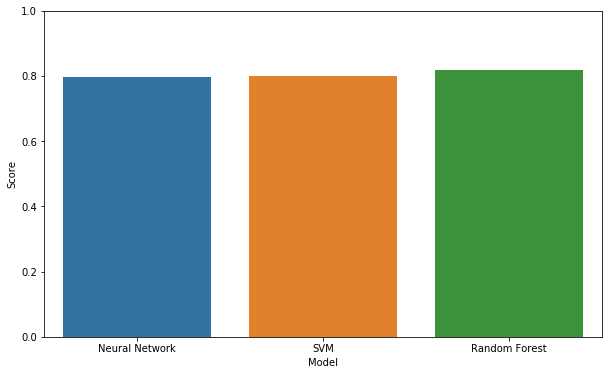

In [37]:
plt.figure(figsize=(10,6))
plot=sns.barplot(x='Model', y='Score', data=results)
plot.set(ylim=(0, 1))
plt.show()

# Summary

The results show that Random Forest was the best classifier for this task basing on the state of the dataset and the parameters that were evaluated during GridSearch. The difference between the algorithms was quite small - about 1%.

## Possible Future Work

There are still some possible approaches that might increase the efficiency of the classification task:
* change the way missing 'Age' was calculated - for instance set it on the basis of the 'Name' value - people with some titles tend to be older
* use different models - there are plenty of models that can be applied to this task: Logistic Regression or Naive Bayes
* explore another parameters of currently used models